## Retrieve pollution observation data

This notebook addresses the collection of pollution statistics reported to the EEA.

To run this notebook, start Jupyter as follows from the Django project root: <br>
(https://medium.com/ayuth/how-to-use-django-in-jupyter-notebook-561ea2401852)

`python manage.py shell_plus --notebook`

<br>
NOTE:  You will need to changed the kernel from menu: `Kernel` > `Change kernel` > `Django Shell-Plus`

References to data sources:
Regions self-report statistics from observation stations and report the data to the EEA.  These data are collected at: <br> https://www.eea.europa.eu/themes/air/dm#b_start=0&c1=Data.

The data can be downloade via REST as described at: <br>
http://discomap.eea.europa.eu/map/fme/AirQualityExport.htm

This notebook will focus on downloading the self-reported statistics and saving them to the application's database.



### Target Measurement
For target measurement, the averaging_period for any record can be one of the following:

- calendar_year : measured as the average for the year
- one_day: measured as the number of times the daily average exceeds the value. 
- max_8hour_mean: measured as the number of days where the limit is exceded at least once in the day.
- hour: measured as the number of hours a measure is exceeded in a year

Version 2016 Targets - EU <br>
https://www.eea.europa.eu/data-and-maps/figures/air-quality-standards-under-the <br>
https://ec.europa.eu/environment/air/quality/standards.htm

|Pollutant|Averaging Period|Yearly Count Limit  |Value|unit |
|---------|----------------|-----------         |-----|-----|
|PM25     |Calendar Year   |None                |25   |ug/m3|
|PM10     |Day             |35                  |50   |ug/m3|
|PM10     |Calendar Year   |None                |40   |ug/m3|
|O3       |Max 8-hour mean |25 (3/yr avg)       |120  |ug/m3|
|NO2      |hour            |18                  |200  |ug/m3|
|NO2      |Calendar Year   |None                |40   |ug/m3|

(this is a simpified version of the targets for prototype application)

### Reporting Metrics

See Annex A for details on the metrics for each pollutant.
https://www.eionet.europa.eu/aqportal/doc/ETC_Aggregation_v0.8.2_final.pdf

The following metrics are used for attainment reporting.  Each pollutants has its own metrics:

|Pollutant|Metrics|
|---------|-------|
| As in PM10 | ['Annual mean / average'] |
| BaP in PM10 | ['Annual mean / average'] |
| C6H6       | ['Annual mean / average'] |
| CO         | ['Days in exceedance in a calendar year'] |
| Cd in PM10 | ['Annual mean / average'] |
| NO2        | ['Annual mean / average'|
||'Hours in exceedance in a calendar year'] |
| NOX as NO2 | ['Annual mean / average'] |
| Ni in PM10 | ['Annual mean / average'] |
| O3         | ['AOT40 vegetation protection'
||'AOT40 vegetation protection averaged over 5 years'|
||'Days in exceedance averaged over 3 calendar years'|
||'Days in exceedance in a calendar year'] |
| PM10       | ['Annual mean / average'|
||'Days in exceedance in a calendar year'] |
| PM2.5      | ['Annual mean / average'|
||'Average Exposure Indicator'] |
| Pb in PM10 | ['Annual mean / average'] |
| SO2        | ['Annual mean / average'|
||'Days in exceedance in a calendar year'|
||'Hours in exceedance in a calendar year' 'Winter Mean'] |

Many more pollutants than these are collected, but only these are measured for target attainment.

### Get average levels for entire day
https://www.eionet.europa.eu/aqportal/doc/ETC_Aggregation_v0.8.2_final.pdf <br>
<br>
**Daily Average (24-hour Mean)** (section 4.1): <br> 
"The daily average or daily mean derived from a sample period of one day."
<br>
(http://dd.eionet.europa.eu/vocabularyconcept/aq/primaryObservation/day/view)
<br><br>
**8-hour running mean** (section 4.2): <br>
"Definition: The 8-hour running mean value for each hour is calculated as the average of the valid hourly values for that hour and the 7 previous hours (therefore cumulatively and 8-hour averaging period). Hence, the averaging period of hour1 of dayn is hour17 of dayn-1 until hour1 of dayn (inclusive). The averaging period of hour24 of dayn is hour16 of dayn until hour24 of dayn (inclusive)." <br>
<br>
**Daily Maximum 8-hour running mean** (section 4.3): <br>
Definition: The daily maximum 8-hour running mean is the maximum of the valid 8-hour running means for that day. Calculation of all the 8-hour running means (above) for a given day is a pre- requisite. A day runs from hour1 to hour24 as defined above.



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import logging
import netCDF4
import re
import os
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import time
import string
import datetime
import pytz
import random
import math

In [3]:
import geopandas as gpd
from shapely.geometry import LineString, Polygon, Point

In [4]:
try:
    from django.db import models
    from airpollution.models.models_observations import *
    from airpollution.models.models_nuts import *
    from airpollution.views.aq_api_v1 import *

    from eugreendeal.settings import MEDIA_ROOT
except Exception as e:
    print("NOT LOADED:  start notebook with:\n")
    print("\tpython manage.py shell_plus --notebook")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [5]:
logger = logging.getLogger("model_logger")
logger.setLevel(logging.ERROR)

## Retrieving Observation Data
In addition to collecting data for target achievment purposes, data is retrieved for reporting purposes.  This includes a variety of options for sumarrizing by year, month, day, country, nuts region and pollutant.

Pandas is used to make this task easier.  After the proper Pandas dataframe is built, it is converted into the desired return dictionary format.

### Daily Average Values

In [7]:
# @staticmethod
def _get_rs_year_dayavg_by_countries(country_codes: list, year: int, logger: logging.Logger,
                                     pollutants: list = None):
    """
    Returns a recordset based on parameters from the ObservationStationReading model.
    If no pollutants are listed, all pollutants are returned.
    """

    if pollutants is None:
        pollutants = list(Pollutant.get_observation_pollutants().keys())
    try:
        rs = ObservationStationReading.objects.filter(country_code__in=country_codes,
                                                      date_time__year=year,
                                                      validity=1,
                                                      pollutant__in=map(str.upper, pollutants)).values(
            'date_time__year',
            'date_time__month',
            'date_time__day',
            'country_code',
            'pollutant__key') \
            .annotate(Avg('value'))

    except Exception as e:
        logger.info(f"'{country_codes}' is not an EU country.")
        return None

    if len(rs) == 0:
        logger.info(f"No records: {country_codes} {year} {pollutants}")
        return None

    return rs

In [8]:
# @staticmethod
def _make_dataframe_bydayavg(rs, year_prefix, logger: logging.Logger) -> pd.DataFrame:
    """
    Creates a dataframe from a record set
    :param rs: Record set from the ObservationStationsReadings model
    :return: Dataframe
    """

    if rs is None or len(rs) == 0:
        return pd.DataFrame()

    r_list = [[datetime.datetime(year=r['date_time__year'],
                                 month=r['date_time__month'],
                                 day=r['date_time__day']), r['country_code'], r['pollutant__key'], r['value__avg']]
              for r in rs]

    df = pd.DataFrame(r_list, columns=['date_time',
                                       'country_code',
                                       'pollutant__key',
                                       'value__avg']).sort_values(by='date_time').reset_index(drop=True)
    df['value__avg'] = pd.to_numeric(df['value__avg'])

    # split table into tables by pollutant
    p_list = df.pollutant__key.unique()
    df_list = []

    # for each data_frame calculate running statistics
    for p in p_list:
        d = df[df.pollutant__key == p].copy()
        d[f'{year_prefix}ytd-avg-level'] = pd.Series(d.value__avg.expanding().mean())
        df_list.append(d)

    rv_df = pd.concat(df_list)

    # add year_day
    rv_df['year_day'] = rv_df.apply(lambda s: s.date_time.timetuple().tm_yday, axis=1)

    return rv_df.rename(columns={'value__avg': f'{year_prefix}day-avg-level'}).sort_values(
        by=['pollutant__key', 'date_time'])

In [22]:
# @staticmethod
def _combine_into_df(rs_PY, rs_CY, logger: logging.Logger) -> pd.DataFrame:

    df_PY = ObservationStationReading._make_dataframe_bydayavg(rs_PY, 'prior-', logger)
    df_CY = ObservationStationReading._make_dataframe_bydayavg(rs_CY, '', logger)

    if len(df_PY) == 0 and len(df_CY) > 0:
        df_CY = df_CY.rename(columns=({'date_time': 'date_time_CY'}))
        df_CY['prior-ytd-avg-level'] = pd.Series([0 for i in range(len(df_CY))])
        df_CY['prior-day-avg-level'] = pd.Series([0 for i in range(len(df_CY))])
        return df_CY

    if len(df_CY) == 0:
        return pd.DataFrame()

    if len(df_CY) == 0 and len(df_PY) == 0:
        return pd.DataFrame()

    return pd.merge(left=df_PY, right=df_CY, how='outer',
                    on=['country_code', 'pollutant__key', 'year_day'],
                    suffixes=('_PY', '_CY'))

# @staticmethod
def _get_daily_df(country_code: str, current_year: int, pollutants: list, logger: logging.Logger) -> pd.DataFrame:
    """
    Returns daily averages and running averages for provided year and prior year.
    """
    rs_PY = ObservationStationReading._get_rs_year_dayavg_by_country(country_code, current_year - 1, logger,
                                                                     pollutants)
    rs_CY = ObservationStationReading._get_rs_year_dayavg_by_country(country_code, current_year, logger, pollutants)

    return ObservationStationReading._combine_into_df(rs_PY, rs_CY, logger)

In [23]:
# @staticmethod
def _get_daily_countries_df(country_codes: list, current_year: int, pollutants: list,
                            logger: logging.Logger) -> pd.DataFrame:
    """
    Returns daily averages and running averages for provided year and prior year.
    """
    rs_PY = ObservationStationReading._get_rs_year_dayavg_by_countries(country_codes, current_year - 1, logger,
                                                                       pollutants)
    rs_CY = ObservationStationReading._get_rs_year_dayavg_by_countries(country_codes, current_year, logger,
                                                                       pollutants)

    return ObservationStationReading._combine_into_df(rs_PY, rs_CY, logger)

In [27]:
# @staticmethod
def get_pollutant_dayavg_by_station_df(date_from: str, date_to: str, pollutants: list):
    # parse dates
    s_year, s_month, s_day = [int(s) for s in date_from.split('-')]
    e_year, e_month, e_day = [int(s) for s in date_to.split('-')]

    tz = pytz.timezone("CET")
    date_from = datetime.datetime(year=s_year, month=s_month, day=s_day, tzinfo=tz)  # '2020-01-01'
    date_to = datetime.datetime(year=e_year, month=e_month, day=e_day, tzinfo=tz)  # '2020-04-30'

    readings_rs = ObservationStationReading.objects.filter(pollutant__key__in=pollutants).filter(
        date_time__gte=date_from,
        date_time__lte=date_to, validity=1).values(
        'air_quality_station_id',
        'pollutant_id').annotate(Avg('value'))
    readings_df = pd.DataFrame(readings_rs).rename(columns={'air_quality_station_id': 'air_quality_station'})
    return readings_df

In [39]:
# @staticmethod
def daily(start_date: str, end_date: str,
          countries: list = None, pollutants: list = None,
          logger: logging.Logger = model_logger) -> dict:
    """
            Returns the daily statistic of 'day-avg-level' and 'ytd-avg-level' for countries and pollutants
            provided in the argument lists.
            :param logger:
            :param start_date: YYYY-MM-DD string of start date
            :param end_date: YYYY-MM-DD string of end date
            :param countries: List of iso codes of countries
            :param pollutants: List of key string values of pollutants
            :return: Dictionary with daily statistics per pollutant per country
    """

    c_dict = {}
    s_year, s_month, s_day = [int(s) for s in start_date.split('-')]
    e_year, e_month, e_day = [int(s) for s in end_date.split('-')]

    # start_year and end_year must be the same year
    if s_year != e_year:
        return {'error': f'Can only produce results an range of dates within a single year. {s_year}-{e_year}'}

    if countries is None:
        countries = EU_ISOCODES

    if pollutants is None:
        pollutants = Pollutant.get_keys()
        
    df = _get_daily_countries_df(countries, e_year, pollutants, logger)
    
    for c in countries:
        c_df = df[df['country_code'] == c]
        if len(c_df) == 0:
            continue

        # filter for dates requested
        s_date = datetime.datetime(year=s_year, month=s_month, day=s_day)
        e_date = datetime.datetime(year=e_year, month=e_month, day=e_day)
        c_df = c_df[(c_df['date_time_CY'] >= s_date) & (c_df['date_time_CY'] <= e_date)]

        c_pollutants = c_df['pollutant__key'].unique()

        # get unique days for current year
        cy_dates = c_df['date_time_CY'].unique()

        d_dict = {}
        for cy_date in cy_dates:
            p_dict = {}
            day_df = c_df[c_df['date_time_CY'] == cy_date]

            for p in c_pollutants:
                p_df = day_df[day_df['pollutant__key'] == p]

                if len(p_df) == 0:
                    p_dict.update({p: {'day-avg-level': None,
                                       'ytd-avg-level': None,
                                       'prior-day_avg_level': None,
                                       'prior-ytd-avg-level': None}})
                else:
                    p_df = p_df.iloc[0]
                    p_dict.update({p: {'day-avg-level': p_df['day-avg-level'],
                                       'ytd-avg-level': p_df['ytd-avg-level'],
                                       'prior-day_avg_level': p_df['prior-day-avg-level'],
                                       'prior-ytd-avg-level': p_df['prior-ytd-avg-level']}})
            d_dict.update({cy_date.astype(str).split('T')[0]: p_dict})

        c_dict.update({c: d_dict})

    return c_dict



In [40]:
logger = logging.getLogger("model_logger")
logger.setLevel(logging.ERROR)

In [42]:
rv = daily('2020-03-01', '2020-04-30', ['BE'], logger=logger)
rv

{'BE': {'2020-03-01': {'NO2': {'day-avg-level': 4.790322580645161,
    'ytd-avg-level': 13.468591777530854,
    'prior-day_avg_level': 13.636363636363637,
    'prior-ytd-avg-level': 30.15308350792314},
   'PM10': {'day-avg-level': 13.967010309278367,
    'ytd-avg-level': 19.900945565374013,
    'prior-day_avg_level': 27.095833333333367,
    'prior-ytd-avg-level': 27.53235269046238},
   'CO': {'day-avg-level': 0.1881818181818182,
    'ytd-avg-level': 0.2601695423844391,
    'prior-day_avg_level': nan,
    'prior-ytd-avg-level': nan},
   'O3': {'day-avg-level': 71.125,
    'ytd-avg-level': 51.42440087643392,
    'prior-day_avg_level': nan,
    'prior-ytd-avg-level': nan},
   'PM25': {'day-avg-level': 5.231958762886598,
    'ytd-avg-level': 10.659017914316589,
    'prior-day_avg_level': nan,
    'prior-ytd-avg-level': nan},
   'SO2': {'day-avg-level': 6.24468085106383,
    'ytd-avg-level': 8.503255732163808,
    'prior-day_avg_level': nan,
    'prior-ytd-avg-level': nan}},
  '2020-03-02':

## Test the Daily API Interface function from Django
Requires Django server to be running <br>
`python manage.py runserver`

In [9]:
# test for current year
rv = ObservationStationReading.daily('2020-02-01', '2020-02-20', ['NL'], ['PM25', 'PM10'])
rv

{'NL': {'2020-02-01': {'PM10': {'day-avg-level': 14.9961035422343,
    'ytd-avg-level': 17.742976383650955,
    'prior-day_avg_level': 25.6216602316602,
    'prior-ytd-avg-level': 21.282782713594457},
   'PM25': {'day-avg-level': 4.56788321167883,
    'ytd-avg-level': 11.12907367462277,
    'prior-day_avg_level': 20.1156897880539,
    'prior-ytd-avg-level': 13.73899316074431}},
  '2020-02-02': {'PM10': {'day-avg-level': 20.7547891156463,
    'ytd-avg-level': 17.83424343613566,
    'prior-day_avg_level': 33.4319338422392,
    'prior-ytd-avg-level': 21.650938808401875},
   'PM25': {'day-avg-level': 5.66115090909091,
    'ytd-avg-level': 10.96337904536423,
    'prior-day_avg_level': 29.2305755919854,
    'prior-ytd-avg-level': 14.2084350526001}},
  '2020-02-03': {'PM10': {'day-avg-level': 25.9144192634561,
    'ytd-avg-level': 18.07189566635097,
    'prior-day_avg_level': 15.3450573248408,
    'prior-ytd-avg-level': 21.465471705944196},
   'PM25': {'day-avg-level': 7.59293097014926,
    '

In [10]:
# test for prior year
rv = ObservationStationReading.daily('2019-02-01', '2019-02-20', ['NL'], ['PM25', 'PM10'])
rv

{'NL': {'2019-02-01': {'PM10': {'day-avg-level': 25.6216602316602,
    'ytd-avg-level': 21.282782713594464,
    'prior-day_avg_level': None,
    'prior-ytd-avg-level': None},
   'PM25': {'day-avg-level': 20.1156897880539,
    'ytd-avg-level': 13.73899316074431,
    'prior-day_avg_level': None,
    'prior-ytd-avg-level': None}},
  '2019-02-02': {'PM10': {'day-avg-level': 33.4319338422392,
    'ytd-avg-level': 21.650938808401882,
    'prior-day_avg_level': None,
    'prior-ytd-avg-level': None},
   'PM25': {'day-avg-level': 29.2305755919854,
    'ytd-avg-level': 14.2084350526001,
    'prior-day_avg_level': None,
    'prior-ytd-avg-level': None}},
  '2019-02-03': {'PM10': {'day-avg-level': 15.3450573248408,
    'ytd-avg-level': 21.465471705944204,
    'prior-day_avg_level': None,
    'prior-ytd-avg-level': None},
   'PM25': {'day-avg-level': 11.7445924528302,
    'ytd-avg-level': 14.13596909378334,
    'prior-day_avg_level': None,
    'prior-ytd-avg-level': None}},
  '2019-02-04': {'PM10'

### Annual Averages - model_observations.py

In [56]:
def annual(years: list = None, countries: list = None, pollutants: list = None, logger: logging.Logger = model_logger) -> dict:
    
    if countries is None:
        countries = EU_ISOCODES
        
    if pollutants is None:
        pollutants = list(Pollutant.get_observation_pollutants().keys())
        
    if years is None:
        years = []
        u_years_rs = ObservationStationReading.objects.filter(country_code__in=countries,validity=1,
                                                      pollutant__in=map(str.upper, pollutants)).values('date_time__year').distinct()
        for item in u_years_rs:
            years.append(list(item.values())[0])

    years.sort()    
        
    # craete dataframe of all years
    df = pd.DataFrame()
    for year in years:    
        try:
            rs = ObservationStationReading.objects.filter(country_code__in=countries,
                                                          date_time__year=year,
                                                          validity=1,
                                                          pollutant__in=map(str.upper, pollutants)).values(
                'date_time__year',
                'country_code',
                'pollutant__key') \
                .annotate(Avg('value'))

        except Exception as e:
            logger.info(f"{e}")
            continue

        if rs is None or len(rs) == 0:
            logger.info(f"No records in {year}")
            continue
        
        df = df.append(pd.DataFrame(rs))
        
    # create dictionary formatted per requirements
    rv_dict = {}
    u_countries = df.country_code.unique()
    for c in u_countries:
        u_years = df[df.country_code==c].date_time__year.unique()
        y_dict = {}
        
        for y in u_years:
            xx_df = df[(df.country_code==c) & (df.date_time__year==y)]
            y_dict.update({y: dict(zip(xx_df['pollutant__key'], xx_df['value__avg']))})
        rv_dict.update({c: y_dict})
        
    return rv_dict
    

In [57]:
x_dict = annual(logger=logger)

In [58]:
x_dict

{'AT': {2018: {'O3': 75.15132152747485},
  2019: {'CO': 0.305983095925527,
   'NO': 2.076520077509071,
   'NO2': 16.083315480413777,
   'O3': 57.19701880073623,
   'PM10': 15.932956449972327,
   'SO2': 1.5835550527824607},
  2020: {'CO': 0.382573216530734,
   'NO': 4.112465034626918,
   'NO2': 22.08223076464752,
   'O3': 51.811997428917074,
   'PM10': 18.510973234801604,
   'SO2': 3.2605644518881918}},
 'BE': {2018: {'NO2': 21.76629853936587, 'PM10': 22.291404239647207},
  2019: {'NO2': 19.768634287088243, 'PM10': 23.565497626617923},
  2020: {'CO': 0.25707232568211397,
   'NO2': 14.049043648847475,
   'O3': 56.239900041649314,
   'PM10': 23.401217538723213,
   'SO2': 9.540168776371308}},
 'BG': {2018: {'CO': 0.675,
   'NO': 26.46,
   'NO2': 20.63,
   'PM10': 49.42919219632313,
   'SO2': 5.386418483060145},
  2019: {'CO': 0.4531235534544732,
   'NO': 18.393648541464678,
   'NO2': 27.989296626633735,
   'O3': 45.129358583565704,
   'PM10': 38.225256225648096,
   'SO2': 11.90852775543044

## Test the Annual API Interface function from Django
Requires Django server to be running <br>
`python manage.py runserver`

In [6]:
ObservationStationReading.annual()# years=[2019, 2020, 2021])


{'AT': {2018: {'O3': 75.15132152747485},
  2019: {'CO': 0.30598309592552736,
   'NO': 2.0765200775090826,
   'NO2': 16.08331548041387,
   'O3': 57.197018800736345,
   'PM10': 15.93295644997233,
   'SO2': 1.5835550527824607},
  2020: {'CO': 0.38257321653073384,
   'NO': 4.1124650346269265,
   'NO2': 22.08223076464751,
   'O3': 51.81199742891704,
   'PM10': 18.510973234801583,
   'SO2': 3.2605644518882007}},
 'BE': {2018: {'NO2': 21.76629853936587, 'PM10': 22.2914042396474},
  2019: {'NO2': 19.768634287088243, 'PM10': 23.565497626618946},
  2020: {'CO': 0.25707232568211424,
   'NO2': 14.049043648847475,
   'O3': 56.239900041649314,
   'PM10': 23.401217538723362,
   'SO2': 9.540168776371308}},
 'BG': {2018: {'CO': 0.675,
   'NO': 26.46,
   'NO2': 20.63,
   'PM10': 49.42919219632312,
   'SO2': 5.386418483060146},
  2019: {'CO': 0.45312355345447286,
   'NO': 18.39364854146469,
   'NO2': 27.989296626633692,
   'O3': 45.129358583565725,
   'PM10': 38.225256225648,
   'SO2': 11.90852775543041}

## Toy Dataset Loading Process
Toy data loads will limit the amount of data loaded.  There are 7500 observation stations in the EU that collect pollution data.  These are spread across all EU countries.  To limit the data load, a subset of stations will be loaded.

In [7]:
def get_stratified_stations(level:int = 1, n:int=1, frac:float=None) -> list:
    """
    Get a list of stations that are stratified based on the nuts level provided.
    Levels 0,1,2,3 return the number of following 26, 86, 219, 900, respectively.
    There are approximately 5000 stations in total.
    """

    # get the observation stations
    rs = ObservationStation.objects.values()

    # create a dictionary of the records
    rs_dict = {x['air_quality_station']:x for x in rs}

    # make it a dataframe
    df = pd.DataFrame(rs_dict).T

    # select 1 station from each nuts3 id
    nuts_levels = [df.country_code_id, df.nuts_1_id, df.nuts_2_id, df.nuts_3_id]
    nuts_level = nuts_levels[level]

    u_nuts = nuts_level.unique()

    station_ids = []
    for reg in u_nuts:
        if frac is None:
            station_ids += df[nuts_level == reg].air_quality_station.sample(n=n).values.tolist()
        else:
            station_ids += df[nuts_level == reg].air_quality_station.sample(frac=frac).values.tolist()
        
    return station_ids


In [8]:
# This list of stations can be passed to the load_data() function
x = get_stratified_stations(level=3, n=1, frac=None)
len(x)

900

In [7]:
# test from application
x = ObservationStation.get_stratified_stations(level=3, n=1, frac=None)

In [8]:
len(x)

900

##  Validate the selection by looking at station points on a map

In [ ]:
df = 

In [9]:
rs_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(rs_df.longitude, rs_df.latitude))


NameError: name 'df' is not defined

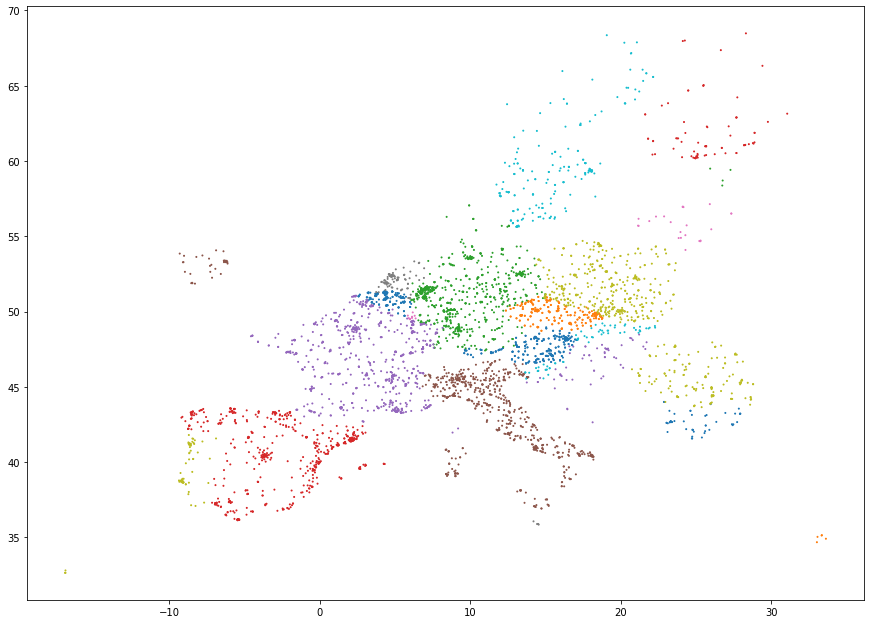

In [50]:
# all stations
rs_gdf.plot(markersize=1, figsize=(15,15), categorical = True, column='country_code_id');

In [120]:
# select 1 station from each nuts3 id
detail = 3 #0,1,2,3  (# stations are 26, 86, 219, 900)
region = [rs_gdf.country_code_id, rs_gdf.nuts_1_id, rs_gdf.nuts_2_id, rs_gdf.nuts_3_id]

u_nuts = region[detail].unique()

station_ids = []
for n in u_nuts:
    station_ids.append(rs_gdf[region[detail] == n].air_quality_station.sample(1).values[0])

len(station_ids), len(rs_gdf)
    


(900, 5002)

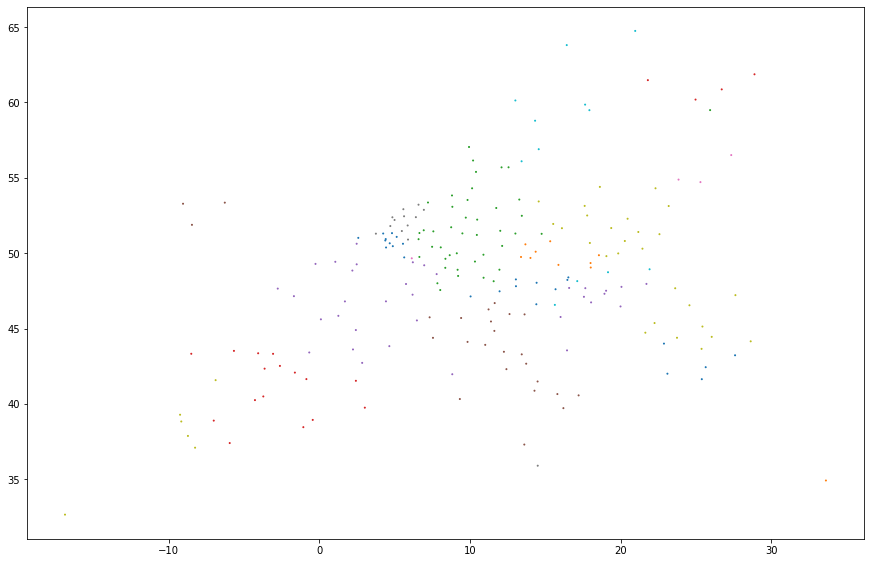

In [116]:
# selected stations
rs_gdf[rs_gdf.air_quality_station.isin(station_ids)].plot(markersize=1, figsize=(15,15), categorical = True, column='country_code_id');


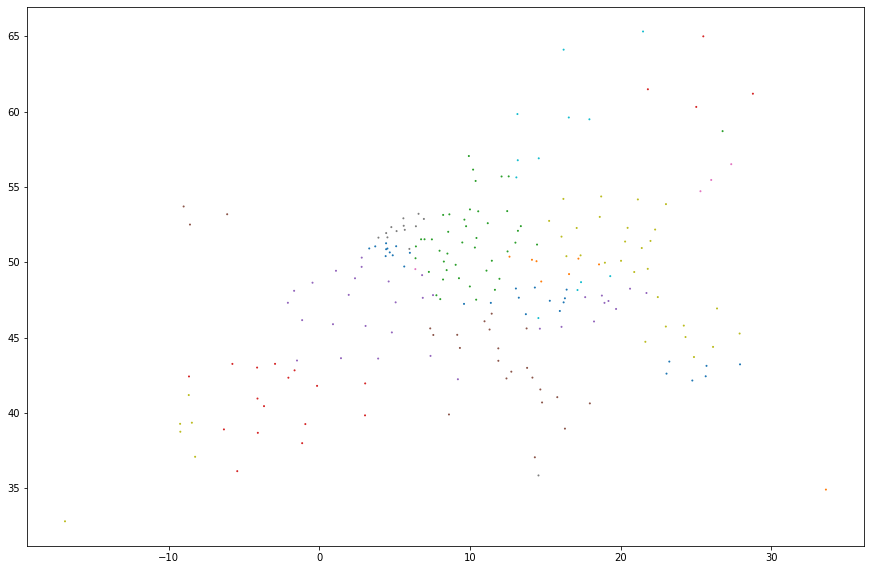